# 4、调用alpha101、alpha191、技术因子、candleresearch或者自己创造衍生因子，要求：任意两个因子，进行画图观察，主要例子看alpha101research和candleresearch，写研究报告（画了什么因子，思考了什么现象，对现象进行描述）


https://github.com/ChannelCMT/formula/wiki

数据类型和周期自定

In [14]:
import warnings
from jaqs_fxdayu.data.dataservice import LocalDataService
warnings.filterwarnings('ignore')
ds = LocalDataService()

#加freq参数
path = r'./min_data/VnTrader_1Min_Db'
props = {'fields': 'open,high,low,close,volume',
         'symbol': 'BTCUSDT:binance',
         'freq': '1H',
         'start_date':20180601000000}

#读取数据
Time_dict = ds.bar_reader(path,props) 

from jaqs_fxdayu.data.hf_dataview import HFDataView
dv1H = HFDataView()
dv1H.create_init_dv(Time_dict.dropna().set_index(["trade_date","symbol"]))

Initialize dataview success.


# 1.Boll

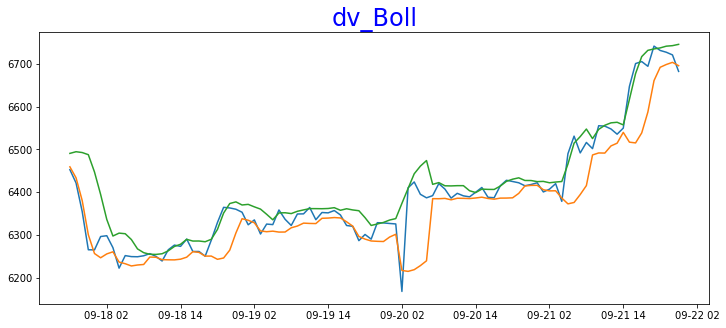

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
def plot_Boll(dv,BollDown,BollUp,chart_name='dv_Boll',n=0):
    fig,(ax) = plt.subplots(1,1,sharex=True, figsize=(12,5))
    ax.plot(dv.get_ts('close', date_type='datetime').iloc[:,0].iloc[n:])
    ax.set_title(chart_name,fontsize=24,color='b') 
    ax.plot(BollDown.iloc[n:],alpha=1)
    ax.plot(BollUp.iloc[n:],alpha=1)
    plt.show()

MA_j = dv1H.add_formula('MA_j', "Ts_Mean(close,5)", add_data=True)
MD_j = dv1H.add_formula('MD_j', 'StdDev(close,5)',  add_data=True)
BollDown_j = dv1H.add_formula('BollDown_j', 'MA_j-1.1*MD_j',  add_data=True)
BollUp_j = dv1H.add_formula('BollUp_j', 'MA_j+1.1*MD_j',  add_data=True)

BollDown = dv1H.get_ts('BollDown_j', date_type='datetime')
BollUp = dv1H.get_ts('BollUp_j', date_type='datetime')

plot_Boll(dv1H, BollDown.iloc[:,0], BollUp.iloc[:,0], n=-100)

# 2. MACD

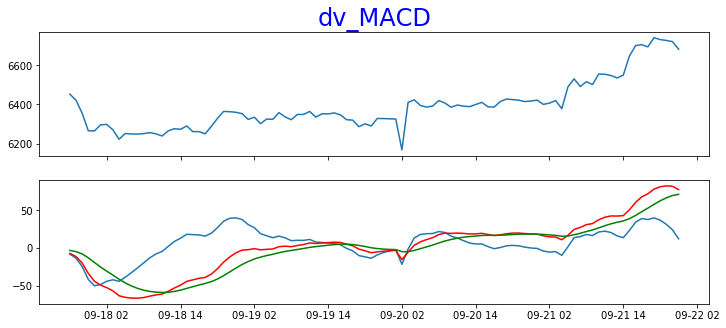

In [3]:
import matplotlib.pyplot as plt
import pandas as pd
def plot_MACD(dv, MACD, Diff, Dea, chart_name='dv_MACD', n=0):
    fig,(ax,ax1) = plt.subplots(2,1,sharex=True, figsize=(12,5))
    ax.plot(dv.get_ts('close', date_type='datetime').iloc[:,0].iloc[n:])
    ax.set_title(chart_name,fontsize=24,color='b') 
    ax1.plot(MACD.iloc[n:], alpha=1)
    y1 = MACD.iloc[n:]
    ax1.plot(Diff.iloc[n:], alpha=1,color='r')
    ax1.plot(Dea.iloc[n:], alpha=1,color='g')
    plt.show()

dv1H.add_formula('Diff_J',"Ta('EMA',0,0,0,0,close,0,12)-Ta('EMA',0,0,0,0,close,0,26)", add_data=True)
dv1H.add_formula('Dea_J',"Ta('EMA',0,0,0,0,Diff_J,0,9)", add_data=True)
dv1H.add_formula('MACD_J',"(Diff_J-Dea_J)*2",add_data=True)

MACD = dv1H.get_ts('MACD_J', date_type='datetime')
Diff = dv1H.get_ts('Diff_J', date_type='datetime')
Dea = dv1H.get_ts('Dea_J', date_type='datetime')

plot_MACD(dv1H, MACD.iloc[:,0], Diff.iloc[:,0], Dea.iloc[:,0], n=-100)

# 5、观察两个因子，和价格图有什么联系，如果是蜡烛图，和成交量有什么联系，怎么找到相应的信号，提出自己信号进出场的假设。（分别完成两个因子的信号假设）

信号进出场假设：可以借鉴MastatiscResearch，但不要将思路假设局限在均线上，可以观察大盘上的其他现象来写信号假设，也可以进行同时满足多个因子的信号来设计信号假设等等。
此处需要说出联系、找到的信号、你的信号进出场假设是什么

# 1.Boll

# 2.MACD

# 6、将你的其中一个假设落实，如果能完成两个更好，但不强求

利用TimingSignal最后输出long、short、long_short这三个绩效表出来

# 1.Boll

In [4]:
#进场信号
longBoll = dv1H.add_formula('longBoll','If((close<Delay(close,1)-5)&&(close<BollDown_j-2)&& (BollDown_j>Delay(BollDown_j,1)-2),2,0)',add_data=True)
shorBoll =dv1H.add_formula('shortBoll','If((close>Delay(close,1)+5)&&(close>=BollUp_j+1) && (BollUp_j<Delay(BollUp_j,1)+1),-2,0)',add_data=True)

#出场信号
closelongBoll = dv1H.add_formula("closelongBoll","If(shortBoll==-2,1,0)", add_data=True)
closeshortBoll = dv1H.add_formula("closeshortBoll","If(longBoll==2,-1,0)", add_data=True)

dv1H.get_ts('longBoll').stack()[dv1H.get_ts('longBoll').stack()==2].head()#观察出现做多信号的时间点

trade_date      symbol         
20180603180000  BTCUSDT:binance    2.0
20180606050000  BTCUSDT:binance    2.0
20180606170000  BTCUSDT:binance    2.0
20180611130000  BTCUSDT:binance    2.0
20180612110000  BTCUSDT:binance    2.0
dtype: float64

In [15]:
from jaqs_fxdayu.research import TimingDigger

tdBoll=TimingDigger(output_folder=".", output_format='pdf',signal_name='Boll')

def TimingSignal(td, dv1H, long='long', short='short',closeLong='closeLong', closeShort='closeShort'\
                 , mhp=None,sl=None,sp=None):

    #多空信号分别计算一遍 输出汇总结果
    td.process_signal(
        enter_signal=dv1H.get_ts(long),
        exit_signal=dv1H.get_ts(closeLong),
        sig_type="long",  # 信号类型 long/short
        price=dv1H.get_ts('close'),
        max_holding_period=mhp,  # 最大持有天数 可为空
        stoploss=-sl,  # 止损百分比 负数 可为空
        stopprofit=sp,  # 止盈百分比 正数 可为空
    )

    td.process_signal(
        enter_signal=dv1H.get_ts(short),
        exit_signal=dv1H.get_ts(closeShort),
        sig_type="short",  # 信号类型 long/short
        price=dv1H.get_ts("close"),
        max_holding_period=mhp,  # 最大持有天数 可为空
        stoploss=-sl,  # 止损百分比 负数 可为空
        stopprofit=sp,  # 止盈百分比 正数 可为空
    )

In [6]:
TimingSignal(tdBoll, dv1H,'longBoll','shortBoll','closelongBoll','closeshortBoll', 6, 0.08, 0.5)#调取数据
tdBoll.create_event_report(sig_type="long")

Nan Data Count (should be zero) : 0;  Percentage of effective data: 1%
Nan Data Count (should be zero) : 0;  Percentage of effective data: 2%
*****-Summary-*****
Event Analysis
                       win    loss     all
t-stat               1.866  -4.155  -0.684
p-value              0.083   0.000   0.498
mean                 0.012  -0.012  -0.002
std                  0.023   0.013   0.021
info_ratio           0.499  -0.907  -0.114
skewness             3.237  -2.006   2.098
kurtosis             9.017   3.274  10.873
pct5                 0.001  -0.043  -0.031
pct25                0.002  -0.013  -0.010
pct50                0.004  -0.009  -0.003
pct75                0.010  -0.004   0.003
pct95                0.041  -0.001   0.014
occurance           15.000  22.000  37.000
win_ratio              NaN     NaN   0.405
win_mean/loss_mean     NaN     NaN   0.965


In [7]:
tdBoll.create_event_report(sig_type="short")

*****-Summary-*****
Event Analysis
                       win    loss     all
t-stat               3.665  -4.300   0.197
p-value              0.002   0.000   0.845
mean                 0.013  -0.010   0.001
std                  0.015   0.011   0.017
info_ratio           0.864  -0.897   0.030
skewness             2.609  -1.640   1.072
kurtosis             7.031   1.645   4.923
pct5                 0.001  -0.034  -0.026
pct25                0.004  -0.011  -0.006
pct50                0.008  -0.005  -0.001
pct75                0.018  -0.003   0.006
pct95                0.029  -0.001   0.023
occurance           19.000  24.000  43.000
win_ratio              NaN     NaN   0.442
win_mean/loss_mean     NaN     NaN   1.387


In [8]:
tdBoll.create_event_report(sig_type="long_short")

*****-Summary-*****
Event Analysis
                       win    loss     all
t-stat               3.744  -5.989  -0.387
p-value              0.001   0.000   0.699
mean                 0.013  -0.011  -0.001
std                  0.019   0.012   0.019
info_ratio           0.652  -0.893  -0.044
skewness             3.185  -1.934   1.671
kurtosis            10.060   3.234   8.983
pct5                 0.001  -0.039  -0.029
pct25                0.003  -0.012  -0.008
pct50                0.006  -0.007  -0.001
pct75                0.014  -0.003   0.004
pct95                0.041  -0.001   0.022
occurance           34.000  46.000  80.000
win_ratio              NaN     NaN   0.425
win_mean/loss_mean     NaN     NaN   1.168


# 2.MACD

In [9]:
# 进场信号
longMACD = dv1H.add_formula("longMACD","If((MACD_J>=0) && (Delay(MACD_J,1)<0),2,0)", add_data=True)
shortMACD = dv1H.add_formula("shortMACD","If((MACD_J<=0) && (Delay(MACD_J,1)>0),-2,0)", add_data=True)

# 出场信号
closelongMACD = dv1H.add_formula("closeLongMACD","If(shortMACD==-2,1,0)", add_data=True)
closeshortMACD = dv1H.add_formula("closeShortMacd","If(longMACD==2,-1,0)", add_data=True)

dv1H.get_ts('longMACD').stack()[dv1H.get_ts('longMACD').stack()==2].head()#观察出现做多信号的时间点

trade_date      symbol         
20180603140000  BTCUSDT:binance    2.0
20180605050000  BTCUSDT:binance    2.0
20180605160000  BTCUSDT:binance    2.0
20180607060000  BTCUSDT:binance    2.0
20180609000000  BTCUSDT:binance    2.0
dtype: float64

In [10]:
from jaqs_fxdayu.research import TimingDigger

tdMACD = TimingDigger(output_folder=".", output_format='pdf',signal_name='MACD')

def TimingSignal(td, dv, long='long', short='short',closeLong='closeLong', closeShort='closeShort'\
                 , mhp=None,sl=None,sp=None):
    # step 1：实例化TimingDigger 通过output_folder和output_format指定测试报告的输出路径和输出格式，通过signal_name指定绩效文件名称

    #多空信号分别计算一遍 输出汇总结果
    td.process_signal(
        enter_signal=dv.get_ts(long),
        exit_signal=dv.get_ts(closeLong),
        sig_type="long",  # 信号类型 long/short
        price=dv.get_ts('close'),
        max_holding_period=mhp,  # 最大持有天数 可为空
        stoploss=-sl,  # 止损百分比 负数 可为空
        stopprofit=sp,  # 止盈百分比 正数 可为空
    )

    td.process_signal(
        enter_signal=dv.get_ts(short),
        exit_signal=dv.get_ts(closeShort),
        sig_type="short",  # 信号类型 long/short
        price=dv.get_ts("close"),
        max_holding_period=mhp,  # 最大持有天数 可为空
        stoploss=-sl,  # 止损百分比 负数 可为空
        stopprofit=sp,  # 止盈百分比 正数 可为空
    )

In [11]:
TimingSignal(tdMACD, dv1H,'longMACD','shortMACD','closeLongMACD','closeShortMACD', 60, 0.05, 0.5)
tdMACD.create_event_report(sig_type="long")

Nan Data Count (should be zero) : 0;  Percentage of effective data: 4%
Nan Data Count (should be zero) : 0;  Percentage of effective data: 4%
*****-Summary-*****
Event Analysis
                       win    loss     all
t-stat               5.471  -6.902   0.226
p-value              0.000   0.000   0.822
mean                 0.016  -0.013   0.000
std                  0.019   0.013   0.022
info_ratio           0.825  -0.966   0.023
skewness             1.745  -1.932   0.780
kurtosis             2.772   4.228   3.128
pct5                 0.000  -0.040  -0.029
pct25                0.002  -0.019  -0.009
pct50                0.008  -0.007  -0.001
pct75                0.024  -0.004   0.007
pct95                0.052  -0.001   0.040
occurance           45.000  52.000  97.000
win_ratio              NaN     NaN   0.464
win_mean/loss_mean     NaN     NaN   1.240


In [12]:
tdMACD.create_event_report(sig_type="short")

*****-Summary-*****
Event Analysis
                       win    loss     all
t-stat               7.762 -10.968  -0.090
p-value              0.000   0.000   0.928
mean                 0.039  -0.034  -0.000
std                  0.033   0.022   0.045
info_ratio           1.170  -1.521  -0.009
skewness             1.017   0.187   0.621
kurtosis             0.361  -1.421  -0.037
pct5                 0.001  -0.061  -0.056
pct25                0.014  -0.053  -0.038
pct50                0.027  -0.035  -0.002
pct75                0.056  -0.011   0.025
pct95                0.098  -0.002   0.082
occurance           45.000  53.000  98.000
win_ratio              NaN     NaN   0.459
win_mean/loss_mean     NaN     NaN   1.151


In [13]:
tdMACD.create_event_report(sig_type="long_short")

*****-Summary-*****
Event Analysis
                       win     loss      all
t-stat               8.766  -11.309    0.015
p-value              0.000    0.000    0.988
mean                 0.027   -0.023    0.000
std                  0.029    0.021    0.036
info_ratio           0.929   -1.109    0.001
skewness             1.461   -0.654    0.708
kurtosis             1.775   -0.995    1.313
pct5                 0.000   -0.058   -0.055
pct25                0.005   -0.042   -0.019
pct50                0.016   -0.015   -0.002
pct75                0.041   -0.005    0.014
pct95                0.085   -0.001    0.073
occurance           90.000  105.000  195.000
win_ratio              NaN      NaN    0.462
win_mean/loss_mean     NaN      NaN    1.170
